# MT3D-USGS: Examples 1a through 1z

We will use a 1D test problem to explore some of the b

In [1]:
# Some needed libraries
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

import config

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy


Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mf2005.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mfnwt.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mp7.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mt3dms.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mt3dusgs.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mf6.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\gridgen.exe


First, create a 1D MODFLOW model for generating a flow field for MT3D-USGS to work with.  We will store the MODFLOW model in an object called 'mf'. 
* A model name of "1D" will be the name given to all MODFLOW input files.
* 1 Row x 100 Columns x 1 Layer x 2 stress periods
* Will be using version: 'mfnwt', or MODFLOW-NWT

In [2]:
modelpth = os.path.join('flopy')
modelname = '1D'
mfexe = 'mfnwt'
mtexe = 'mt3dusgs'

if platform.system() == 'Windows':
    mfexe += '.exe'
    mtexe += '.exe'

# Make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.mkdir(modelpth)

# Instantiate MODFLOW object in flopy
mf = flopy.modflow.Modflow(modelname=modelname, exe_name=config.mfnwtexe, model_ws=modelpth, version='mfnwt')


### Define model dimensions

In [3]:
# Set up model discretization

Lx = 1000.0 
Ly = 10.0
nrow = 1
ncol = 100
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

xmax = ncol * delr
ymax = nrow * delc

X, Y = np.meshgrid(np.linspace(delr / 2, xmax - delr / 2, ncol),    
                   np.linspace(ymax - delc / 2, 0 + delc / 2, nrow))


### Instantiate output control (oc) package for MODFLOW-NWT

In [4]:
# Output Control: Create a flopy output control object
oc = flopy.modflow.ModflowOc(mf)     

### Instantiate solver package for MODFLOW-NWT

In [5]:
# Will use the Newton-Rhapson Solver.  Creating a flopy nwt package object...

headtol = 1.0E-4 
fluxtol = 5      
maxiterout = 5000
thickfact = 1E-06
linmeth = 2      
iprnwt = 1       
ibotav = 1       

nwt = flopy.modflow.ModflowNwt(mf, headtol=headtol, fluxtol=fluxtol, maxiterout=maxiterout,
                               thickfact=thickfact, linmeth=linmeth, iprnwt=iprnwt, ibotav=ibotav,
                               options='SIMPLE')


### Instantiate discretization (DIS) package for MODFLOW-NWT

The flow solution is two stress periods that are the same, rendering the flow solution a steady-state simulation.  However, the 1D transport problem specifies a non-zero concentration in the first stress period which switches to 0 in the second stress period of the transport problem.  Therefore, since the transport simulation is non-steady, we use two transient stress periods in the flow model as well to ensure both models have the same temporal discretization.

In [6]:
grndElv = 5
botm = 0.0

# Stress period info
Steady = [False, False]
nstp = [1, 1]
nper = 2
tsmult = 1.
perlen = [100,3550]

# Create the discretization object
# itmuni = 4 (days); lenuni = 1 (feet)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, nper=nper, delr=delr, delc=delc,     
                               top=grndElv, botm=botm, laycbd=0, itmuni=4, lenuni=2,
                               steady=Steady, nstp=nstp, tsmult=tsmult, perlen=perlen) 


### Instantiate upstream weighting (UPW) flow package for MODFLOW-NWT

In [7]:
# First line of UPW input is: IUPWCB HDRY NPUPW IPHDRY 
hdry = -1.00e+30
iphdry = 0

# Next variables are: LAYTYP, LAYAVG, CHANI, LAYVKA, LAYWET
laytyp = 1          # >0: convertible
layavg = 0          #  0: harmonic mean
chani = 1.0         # >0: CHANI is the horizontal anisotropy for the entire layer
layvka = 0          # =0: indicates VKA is vertical hydraulic conductivity
laywet = 0          # Always set equal to zero in UPW package
hk = 20
# hani = 1          # Not needed because CHANI > 1
vka = 0.5           # Is equal to vert. K b/c LAYVKA = 0
ss = 0.000001
sy = 0.20

upw = flopy.modflow.ModflowUpw(mf, laytyp=laytyp, layavg=layavg, chani=chani, layvka=layvka,
                               laywet=laywet, ipakcb=53, hdry=hdry, iphdry=iphdry, hk=hk, 
                               vka=vka, ss=ss, sy=sy)


### Instantiate basic (BAS or BA6) package for MODFLOW-NWT

In [8]:
ibnd1 = np.ones((nrow, ncol))
sthd1 = np.ones((nrow, ncol)) * 10.

hdry = -999

bas = flopy.modflow.ModflowBas(mf, ibound=ibnd1, hnoflo=hdry, strt=sthd1)

### Instantiate general head boundary (GHB) package for MODFLOW-NWT

In [9]:
# GHB boundaries are use to create a gradient driving flow from left ot right

leftside_hd  = 40.
rightside_hd = 10.
cond         = 100.
elev_slp     = (308.82281 - 298.83649) / (ncol - 1)

sp = []
sp.append([nlay - 1, nrow - 1, 0, leftside_hd, cond])
sp.append([nlay - 1, nrow - 1, ncol - 1, rightside_hd, cond])

ghb = flopy.modflow.ModflowGhb(mf, stress_period_data = sp)


### Instantiate linkage with mass transport routing (LMT) package for MODFLOW-NWT (generates linker file)

In [10]:
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='1D.ftl', output_file_header='extended',
                               output_file_format='formatted')


# Switching gears to MT3D-USGS

Note that by passing the 'mf' object into the instatiation of the MT3D-USGS object ("mt"), many of duplicate datasets - such as model discretization - are set up automatically by flopy

In [11]:
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, model_ws=modelpth,
                       version='mt3d-usgs', namefile_ext='mtnam', exe_name=config.mt3dusgsexe,
                       ftlfilename='1D.ftl', ftlfree=True)

### Instantiate basic transport (BTN) package for MT3D-USGS

In [12]:
ncomp   =   1
lunit   =   'FT'
sconc   =   0.0
prsity  =   sy
cinact  =  -1.0
thkmin  =   0.000001
nprs    =  -1
nprobs  =  10
nprmas  =  10
dt0     =   1.0
nstp    =   1
mxstrn  = 500
ttsmult =   1.0
ttsmax  = 100

#obs = [[0, 104, 158],
#       [1, 104, 158],
#       [2, 104, 158]]

btn = flopy.mt3d.Mt3dBtn(mt, MFStyleArr=True, DRYCell=True, lunit=lunit,
                         sconc=sconc, ncomp=ncomp, prsity=prsity, cinact=cinact,
                         thkmin=thkmin, nprs=nprs, nprobs=nprobs, 
                         chkmas=True,nprmas=nprmas, dt0=dt0, nstp=nstp, 
                         mxstrn=mxstrn, ttsmult=ttsmult, ttsmax=ttsmax)


### Instantiate advection (ADV) package for MT3D-USGS

This is where implicit vs. explicit solution schemes can be selected.  Explicit schemes include a number of different particle tracking approaches.  These may be helpful in advection dominated systems.  For this exercise, we will use the finite-difference method with the third-order __T__otal __V__ariation __D__iminishing (TVD) scheme activated

In [13]:
mixelm =   -1
percel =    1.0000
mxpart = 5000
nadvfd =    1      # (1 = Upstream weighting)

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=percel, mxpart=mxpart, 
                         nadvfd=nadvfd)


### Instatiate source-sink mixing package for MT3D-USGS

We'll track the cell locations for the SSM data using the MODFLOW boundary conditions.

In [14]:
# First, get a dictionary that has the SSM itype for each of the boundary types.
itype = flopy.mt3d.Mt3dSsm.itype_dict()

mxss = 2          # maximum number of boundary conditions
ssm_data = {}
#                    kss,      iss, jss,  css,        ITYPE
ssm_data[0] = [(nlay - 1, nrow - 1,   0, 100., itype['GHB'])]
ssm_data[1] = [(nlay - 1, nrow - 1,   0,   0., itype['GHB'])]

ssm = flopy.mt3d.Mt3dSsm(mt, mxss=mxss, stress_period_data=ssm_data)


### Instantiate generalized conjugate gradient solver (GCG) package for MT3D-USGS

(Currently, this is the only option for solvers)

In [15]:
mxiter =   1
iter1  = 200
isolve =   3
ncrs   =   0
accl   =   1.000000
cclose =   1.00e-06
iprgcg =   5

gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=mxiter, iter1=iter1, 
                         isolve=isolve, ncrs=ncrs, accl=accl, 
                         cclose=cclose, iprgcg=iprgcg)


### Write the MODFLOW & MT3D-USGS input files for inspection and run the model.


In [16]:
mf.write_input()
mt.write_input()

mf.run_model()
mt.run_model()

FloPy is using the following  executable to run the model: c:\bin\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: 1D.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/24  7:08:50

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/10/24  7:08:50
 Elapsed run time:  0.023 Seconds

  Normal termination of simulation
FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Sp

 Transport Step:   97   Step Size:   1.000     Total Elapsed Time:   197.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   98   Step Size:   1.000     Total Elapsed Time:   198.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   99   Step Size:   1.000     Total Elapsed Time:   199.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  100   Step Size:   1.000     Total Elapsed Time:   200.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  101   Step Size:   1.000     Total Elapsed Time:   201.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  102   Step Size:   1.000     Total Elapsed Time:   202.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  103   Step Size:   1.0

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2290      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  308   Step Size:   1.000     Total Elapsed Time:   408.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2290      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  309   Step Size:   1.000     Total Elapsed Time:   409.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2290      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  310   Step Size:   1.000     Total Elapsed Time:   410.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2290      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  311   Step Size:   1.000     Total Elapsed Time:   411.00    
 Outer Iter.  1  Inner Iter.  1:  Max. D

(False, [])

### Post-process model output

##### First, define a function that will be used repeatedly for plotting results. 

In [83]:
def set_plot_params():
    import matplotlib as mpl
    from matplotlib.font_manager import FontProperties
    mpl.rcParams['font.sans-serif']          = 'Arial'
    mpl.rcParams['font.serif']               = 'Times'
    mpl.rcParams['font.cursive']             = 'Zapf Chancery'
    mpl.rcParams['font.fantasy']             = 'Comic Sans MS'
    mpl.rcParams['font.monospace']           = 'Courier New'
    mpl.rcParams['pdf.compression']          = 0
    mpl.rcParams['pdf.fonttype']             = 42
    
    ticksize = 10
    mpl.rcParams['legend.fontsize']  = 9
    mpl.rcParams['axes.labelsize']   = 12
    mpl.rcParams['xtick.labelsize']  = ticksize
    mpl.rcParams['ytick.labelsize']  = ticksize
    return



In [84]:
headobj = bf.HeadFile(os.path.join(modelpth,'{0}.hds'.format('1D')))
ckstpkper = headobj.get_kstpkper()

ucn = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))

totim = ucn.get_times()

rslt = []

for tm in totim:
    rsltTS = ucn.get_data(totim = tm)
    rslt.append(rsltTS)

rslt = np.array(rslt)

# rslt is a numpy array with dimensions [time-steps, layer, row, columns] and contains 
# the model generated concentrations at each of those locations
rslt.shape


(600, 1, 1, 100)

### Have a look at the advection-only solution at two different times

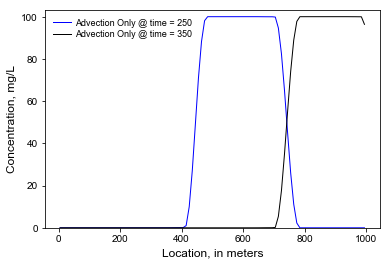

In [85]:
## Set up figure
try:
    plt.close('all')
except:
    pass

set_plot_params()


fig = plt.figure(figsize=(6, 4), facecolor='w')
ax = fig.add_subplot(1, 1, 1)

ax.plot(X[0,:], rslt[249,0,0,:], 'b-', linewidth=1.0)
ax.plot(X[0,:], rslt[349,0,0,:], 'k-', linewidth=1.0)

#customize plot
ax.set_xlabel('Location, in meters')
ax.set_ylabel('Concentration, mg/L')
ax.set_ylim([0,103])
ticksize = 10

#legend
leg = ax.legend(
                (
                 'Advection Only @ time = 250',
                 'Advection Only @ time = 350'
                 ), 
                loc='upper left', labelspacing=0.25, columnspacing=1,
                handletextpad=0.5, handlelength=2.0, numpoints=1)
leg._drawFrame = False 

plt.show()


### Next, adding Dispersion.  Instantiate dispersion (DSP) package for MT3D-USGS

In [87]:
al     = 10.0        # longitudinal dispersivity
trpt   =  0.1        # ratio of the horizontal transverse dispersivity to 'AL'
trpv   =  0.1        # ratio of the vertical transverse dispersitvity to 'AL'
dmcoef =  1.0000e-10

dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef,
                         multiDiff=True)

# with the DSP package turned on, rerun the transport simulation
mt.write_input()
mt.run_model()


****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtdsp.Mt3dDsp'> <class 'flopy.mt3d.mtdsp.Mt3dDsp'>
replacing existing Package...
FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: 1D.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    100.00    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   23.97      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    1    1    6
 Transport Step:    2   Step Size:   1.000     Total Elapsed Time:   2.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.338      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J

 Transport Step:   89   Step Size:   1.000     Total Elapsed Time:   89.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2971      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2118E-21  [K,I,J]    1    1   88
 Transport Step:   90   Step Size:   1.000     Total Elapsed Time:   90.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2971      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   91   Step Size:   1.000     Total Elapsed Time:   91.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2971      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2776E-16  [K,I,J]    1    1   75
 Transport Step:   92   Step Size:   1.000     Total Elapsed Time:   92.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2971      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   93   Step Size:   1.0

 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  188   Step Size:   1.000     Total Elapsed Time:   288.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4888E-01  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  189   Step Size:   1.000     Total Elapsed Time:   289.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5095E-01  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  190   Step Size:   1.000     Total Elapsed Time:   290.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5307E-01  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  191   Step Size:   1.000     Total Elapsed Time:   291.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5527E-01  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  391   Step Size:   1.000     Total Elapsed Time:   491.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2426      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  392   Step Size:   1.000     Total Elapsed Time:   492.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2427      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  393   Step Size:   1.000     Total Elapsed Time:   493.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2428      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  394   Step Size:   1.000     Total Elapsed Time:   494.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

(False, [])

### Post-process: Advection with Dispersion

Having rerun the transport model.  Re-process the model output and compare the 

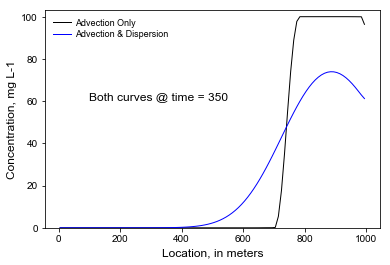

In [92]:
ucn = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))

totim = ucn.get_times()

rslt_dsp = []

for tm in totim:
    rsltTS = ucn.get_data(totim = tm)
    rslt_dsp.append(rsltTS)

rslt_dsp = np.array(rslt_dsp)

rslt_dsp.shape


## Set up figure
try:
    plt.close('all')
except:
    pass

set_plot_params()

fig = plt.figure(figsize=(6, 4), facecolor='w')
ax = fig.add_subplot(1, 1, 1)

ax.plot(X[0,:], rslt[349,0,0,:], 'k-', linewidth=1.0)
ax.plot(X[0,:], rslt_dsp[349,0,0,:], 'b-', linewidth=1.0)

#customize plot
ax.set_xlabel('Location, in meters')
ax.set_ylabel('Concentration, mg L-1')
ax.set_ylim([0,103])
ticksize = 10

#legend
leg = ax.legend(
                (
                 'Advection Only', 'Advection w\ Dispersion'
                 ), 
                loc='upper left', labelspacing=0.25, columnspacing=1,
                handletextpad=0.5, handlelength=2.0, numpoints=1)
leg._drawFrame = False 
ax.text(100, 60, 'Both curves @ time = 350', fontsize=12)

plt.show()


### Next, examine the affects of sorption through the use of the reaction package
### Instantiate reaction (RCT) package for MT3D-USGS

In [93]:
isothm    = 1  # 1: Linear; 2: Freundlich; 3: Langmuir; 4: 1st-order kinetic sorption
ireact    = 0  # 0: no kinetic rate reaction; 1: 1st-order irreversible reaction
irctop    = 2  # >=2: rct variables entered as arrays; <2: rct variables 1D by layer
igetsc    = 0
ireaction = 0
rhob      = 2.0e+3
srconc    = np.zeros((nlay, nrow, ncol))

sp1       = 1.e-4    # Distribution Coefficient (Kd)
sp2       =   0.0    # read, but not used with isothm = 1

rct = flopy.mt3d.Mt3dRct(mt, isothm=isothm, ireact=ireact, igetsc=igetsc,
                         sp1=sp1, srconc=srconc)


### Rerun transport simulation with the RCT package now activated

In [95]:
mt.write_input()
mt.run_model()

FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: 1D.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    100.00    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   13.75      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1490E-07  [K,I,J]    1    1    3
 Transport Step:    2   Step Size:   1.000     Total Elapsed Time:   2.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.099      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    1    1    4
 Transport Step:    3   Step Size:   1.000     Total Elapsed Time:   3.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.597


 TIME STEP NO.    1
 FROM TIME =   100.00     TO    3650.0    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   101.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1868E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5049E-28  [K,I,J]    1    1   77
 Transport Step:    2   Step Size:   1.000     Total Elapsed Time:   102.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2890E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4136E-24  [K,I,J]    1    1   70
 Transport Step:    3   Step Size:   1.000     Total Elapsed Time:   103.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3384E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3009E-35  [K,I,J]    1    1   90
 Transport Step:    4   Step Size:   1.000     Total Elapsed Time:   104.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3585E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000    

 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  173   Step Size:   1.000     Total Elapsed Time:   273.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1678E-02  [K,I,J]    1    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  174   Step Size:   1.000     Total Elapsed Time:   274.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1736E-02  [K,I,J]    1    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  175   Step Size:   1.000     Total Elapsed Time:   275.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1788E-02  [K,I,J]    1    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  176   Step Size:   1.000     Total Elapsed Time:   276.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1765E-02  [K,I,J]    1    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Transport Step:  364   Step Size:   1.000     Total Elapsed Time:   464.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4095E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  365   Step Size:   1.000     Total Elapsed Time:   465.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4260E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  366   Step Size:   1.000     Total Elapsed Time:   466.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4431E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  367   Step Size:   1.000     Total Elapsed Time:   467.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4609E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  368   Step Size:   1.0

(False, [])

### Plot the new results

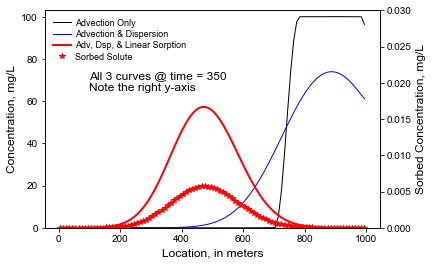

In [104]:
ucn  = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))
ucns = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001s')))

totim = ucn.get_times()

rslt_rct1 = []
rslt_rct1s = []

for tm in totim:
    rsltTS = ucn.get_data(totim = tm)
    rsltTSs = ucns.get_data(totim = tm)
    rslt_rct1.append(rsltTS)
    rslt_rct1s.append(rsltTSs)

rslt_rct1 = np.array(rslt_rct1)
rslt_rct1s = np.array(rslt_rct1s)

rslt_rct1.shape
rslt_rct1s.shape

## Set up figure
try:
    plt.close('all')
except:
    pass

set_plot_params()

fig = plt.figure(figsize=(6, 4), facecolor='w')
ax = fig.add_subplot(1, 1, 1)
ax2 = plt.twinx()

lns1 = ax.plot(X[0,:], rslt[349,0,0,:], 'k-', linewidth=1.0, label = 'Advection Only')
lns2 = ax.plot(X[0,:], rslt_dsp[349,0,0,:], 'b-', linewidth=1.0, label = 'Advection w\ Dispersion')
lns3 = ax.plot(X[0,:], rslt_rct1[349,0,0,:], 'r-', linewidth=2.0, label = 'Adv, Dsp, w\ Linear Sorption')
pts1 = ax2.plot(X[0,:], rslt_rct1s[349,0,0,:], 'r*', linewidth=2.0, label = 'Sorbed Solute')

#customize plot
ax.set_xlabel('Location, in meters')
ax.set_ylabel('Concentration, mg/L')
ax2.set_ylabel('Sorbed Concentration, mg/L')
ax.set_ylim([0,103])
ax2.set_ylim([0,0.03])
ticksize = 10

# add 4 items to legend
lns = lns1+lns2+lns3+pts1
labs = [l.get_label() for l in lns]

#legend
leg = ax.legend(lns, labs, 
                loc='upper left', labelspacing=0.25, columnspacing=1,
                handletextpad=0.5, handlelength=2.0, numpoints=1)
leg._drawFrame = False 
ax.text(100, 70, 'All 3 curves @ time = 350', fontsize=12)
ax.text(100, 65, 'Note the right y-axis', fontsize=12)

plt.show()


### Now add non-equilibrium sorption

Before running the code that follows, what do you think 
non-equilibrium sorption will do to the red curve?
* Slow the advance of solute? 
* Change the shape of the curve?

In [105]:
# Manipulate RCT input variables to simulate non-equilibrium sorption

rct.isothm = 4
rct.sp2[0][0][:] = 1e-3  # Need to set sp2 term

# sticking with the linear isotherm

mt.write_input()
mt.run_model()


FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: 1D.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    100.00    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   23.87      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    1    1    6
 Transport Step:    2   Step Size:   1.000     Total Elapsed Time:   2.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.333      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J]    1    1    4
 Transport Step:    3   Step Size:   1.000     Total Elapsed Time:   3.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.812

 Transport Step:   92   Step Size:   1.000     Total Elapsed Time:   92.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2988      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3309E-23  [K,I,J]    1    1   94
 Transport Step:   93   Step Size:   1.000     Total Elapsed Time:   93.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2988      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   94   Step Size:   1.000     Total Elapsed Time:   94.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2988      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1034E-24  [K,I,J]    1    1   99
 Transport Step:   95   Step Size:   1.000     Total Elapsed Time:   95.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2988      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3309E-23  [K,I,J]    1    1   96
 Transport Step:   96   Step Size:   1.0

 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  158   Step Size:   1.000     Total Elapsed Time:   258.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6515E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  159   Step Size:   1.000     Total Elapsed Time:   259.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6960E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  160   Step Size:   1.000     Total Elapsed Time:   260.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7428E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  161   Step Size:   1.000     Total Elapsed Time:   261.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7920E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Transport Step:  347   Step Size:   1.000     Total Elapsed Time:   447.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2318      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  348   Step Size:   1.000     Total Elapsed Time:   448.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2318      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  349   Step Size:   1.000     Total Elapsed Time:   449.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2318      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  350   Step Size:   1.000     Total Elapsed Time:   450.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2318      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  351   Step Size:   1.0

(False, [])

### Plot the new results

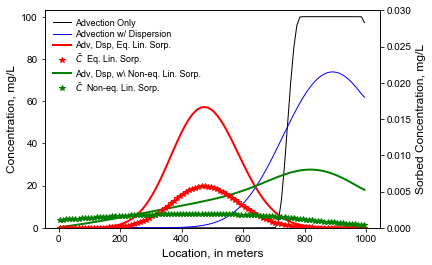

In [112]:
ucn  = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))
ucns = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001s')))

totim = ucn.get_times()

rslt_rcte = []
rslt_rctes = []

for tm in totim:
    rsltTS = ucn.get_data(totim = tm)
    rsltTSs = ucns.get_data(totim = tm)
    rslt_rcte.append(rsltTS)
    rslt_rctes.append(rsltTSs)

rslt_rcte = np.array(rslt_rcte)
rslt_rctes = np.array(rslt_rctes)

rslt_rcte.shape
rslt_rctes.shape

## Set up figure
try:
    plt.close('all')
except:
    pass

set_plot_params()

fig = plt.figure(figsize=(6, 4), facecolor='w')
ax = fig.add_subplot(1, 1, 1)
ax2 = plt.twinx()

lns1 = ax.plot(X[0,:], rslt[350,0,0,:], 'k-', linewidth=1.0, label = 'Advection Only')
lns2 = ax.plot(X[0,:], rslt_dsp[350,0,0,:], 'b-', linewidth=1.0, label = 'Advection w/ Dispersion')
lns3 = ax.plot(X[0,:], rslt_rct1[350,0,0,:], 'r-', linewidth=2.0, label = 'Adv, Dsp, Eq. Lin. Sorp.')
pts1 = ax2.plot(X[0,:], rslt_rct1s[350,0,0,:], 'r*', linewidth=2.0, label = r'$\bar{C}$  Eq. Lin. Sorp.')
lns4 = ax.plot(X[0,:], rslt_rcte[350,0,0,:], 'g-', linewidth=2.0, label = 'Adv, Dsp, w\ Non-eq. Lin. Sorp.')
pts2 = ax2.plot(X[0,:], rslt_rctes[350,0,0,:], 'g*', linewidth=2.0, label = r'$\bar{C}$  Non-eq. Lin. Sorp.')

# add 4 items to legend
lns = lns1+lns2+lns3+pts1+lns4+pts2
labs = [l.get_label() for l in lns]

#customize plot
ax.set_xlabel('Location, in meters')
ax.set_ylabel('Concentration, mg/L')
ax2.set_ylabel('Sorbed Concentration, mg/L')
ax.set_ylim([0,103])
ax2.set_ylim([0,0.03])
ticksize = 10

#legend
leg = ax.legend(lns, labs, 
                loc='upper left', labelspacing=0.25, columnspacing=1,
                handletextpad=0.5, handlelength=2.0, numpoints=1)
leg._drawFrame = False 

plt.show()


##### Do the green lines make sense?

### Now add decay

In [113]:
# Need to manipulate some RCT parameters (see comments below for more details)

rct.isothm = 1            # Turn off non-eq. sorption & switch on linear isotherm
rct.ireact = 1            # This switches on 1st order irreversible reaction
rct.rc1[0][0][:] = 5e-3   # 1st order reaction rate for the dissolved phase
rct.rc2[0][0][:] = 1e-4   # 1st order reaction rate for the sorbed phase

mt.write_input()
mt.run_model()

FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: 1D.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    100.00    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   13.72      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1192E-06  [K,I,J]    1    1    2
 Transport Step:    2   Step Size:   1.000     Total Elapsed Time:   2.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.097      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    1    1    4
 Transport Step:    3   Step Size:   1.000     Total Elapsed Time:   3.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.596

 Transport Step:   96   Step Size:   1.000     Total Elapsed Time:   96.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1584      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3388E-20  [K,I,J]    1    1   60
 Transport Step:   97   Step Size:   1.000     Total Elapsed Time:   97.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1584      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7889E-30  [K,I,J]    1    1   78
 Transport Step:   98   Step Size:   1.000     Total Elapsed Time:   98.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1584      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6311E-29  [K,I,J]    1    1   77
 Transport Step:   99   Step Size:   1.000     Total Elapsed Time:   99.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1584      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4815E-34  [K,I,J]    1    1   86
 Transport Step:  100   Step Size:   1.0

 Transport Step:  179   Step Size:   1.000     Total Elapsed Time:   279.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4417E-02  [K,I,J]    1    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  180   Step Size:   1.000     Total Elapsed Time:   280.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4370E-02  [K,I,J]    1    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  181   Step Size:   1.000     Total Elapsed Time:   281.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4329E-02  [K,I,J]    1    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  182   Step Size:   1.000     Total Elapsed Time:   282.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4334E-02  [K,I,J]    1    1   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  183   Step Size:   1.0

 Transport Step:  383   Step Size:   1.000     Total Elapsed Time:   483.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7818E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  384   Step Size:   1.000     Total Elapsed Time:   484.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8097E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  385   Step Size:   1.000     Total Elapsed Time:   485.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8381E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  386   Step Size:   1.000     Total Elapsed Time:   486.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8672E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  387   Step Size:   1.0

(False, [])

### Plot the results with Decay activated:

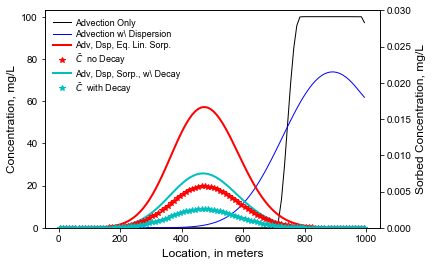

In [115]:
ucn  = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))
ucns = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001s')))

totim = ucn.get_times()

rslt_rct2 = []
rslt_rct2s = []

for tm in totim:
    rsltTS = ucn.get_data(totim = tm)
    rsltTSs = ucns.get_data(totim = tm)
    rslt_rct2.append(rsltTS)
    rslt_rct2s.append(rsltTSs)

rslt_rct2 = np.array(rslt_rct2)
rslt_rct2s = np.array(rslt_rct2s)

## Set up figure
try:
    plt.close('all')
except:
    pass

set_plot_params()

fig = plt.figure(figsize=(6, 4), facecolor='w')
ax = fig.add_subplot(1, 1, 1)
ax2 = plt.twinx()

lns1 = ax.plot(X[0,:], rslt[350,0,0,:], 'k-', linewidth=1.0, label = 'Advection Only')
lns2 = ax.plot(X[0,:], rslt_dsp[350,0,0,:], 'b-', linewidth=1.0, label = 'Advection w\ Dispersion')
lns3 = ax.plot(X[0,:], rslt_rct1[350,0,0,:], 'r-', linewidth=2.0, label = 'Adv, Dsp, Eq. Lin. Sorp.')
pts1 = ax2.plot(X[0,:], rslt_rct1s[350,0,0,:], 'r*', linewidth=2.0, label = r'$\bar{C}$  no Decay')
lns4 = ax.plot(X[0,:], rslt_rct2[350,0,0,:], 'c-', linewidth=2.0, label = 'Adv, Dsp, Sorp., w\ Decay')
pts2 = ax2.plot(X[0,:], rslt_rct2s[350,0,0,:], 'c*', linewidth=2.0, label = r'$\bar{C}$  with Decay')

# add 4 items to legend
lns = lns1+lns2+lns3+pts1+lns4+pts2
labs = [l.get_label() for l in lns]

#customize plot
ax.set_xlabel('Location, in meters')
ax.set_ylabel('Concentration, mg/L')
ax2.set_ylabel('Sorbed Concentration, mg/L')
ax.set_ylim([0,103])
ax2.set_ylim([0,0.03])
ticksize = 10

#legend
leg = ax.legend(lns, labs,
                loc='upper left', labelspacing=0.25, columnspacing=1,
                handletextpad=0.5, handlelength=2.0, numpoints=1)
leg._drawFrame = False 

plt.show()


### Have a look at some of the non-linear isotherms

In [118]:
rct.isothm = 2             # Freundlich
rct.ireact = 0             # Switches off reactions
rct.sp1[0][0][0,:] = 1e-4  # Kf
rct.sp2[0][0][0,:] = 1.25  # alpha

mt.write_input()
mt.run_model()


FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: 1D.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    100.00    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   23.97      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    1    1    6
 Transport Step:    2   Step Size:   1.000     Total Elapsed Time:   2.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3148      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]    1    1    8
 Transport Step:    3   Step Size:   1.000     Total Elapsed Time:   3.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.250

 Transport Step:   95   Step Size:   1.000     Total Elapsed Time:   95.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6837E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1059E-21  [K,I,J]    1    1   87
 Transport Step:   96   Step Size:   1.000     Total Elapsed Time:   96.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6829E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   97   Step Size:   1.000     Total Elapsed Time:   97.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6821E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   98   Step Size:   1.000     Total Elapsed Time:   98.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6813E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   99   Step Size:   1.0

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2016E-02  [K,I,J]    1    1   17
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  166   Step Size:   1.000     Total Elapsed Time:   266.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2040E-02  [K,I,J]    1    1   17
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  167   Step Size:   1.000     Total Elapsed Time:   267.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2041E-02  [K,I,J]    1    1   17
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  168   Step Size:   1.000     Total Elapsed Time:   268.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2022E-02  [K,I,J]    1    1   17
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  169   Step Size:   1.000     Total Elapsed Time:   269.00    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:  360   Step Size:   1.000     Total Elapsed Time:   460.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1266E-02  [K,I,J]    1    1   21
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  361   Step Size:   1.000     Total Elapsed Time:   461.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1263E-02  [K,I,J]    1    1   21
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  362   Step Size:   1.000     Total Elapsed Time:   462.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1259E-02  [K,I,J]    1    1   21
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  363   Step Size:   1.000     Total Elapsed Time:   463.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1255E-02  [K,I,J]    1    1   21
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  364   Step Size:   1.0

(False, [])

### Plot the results after simulating with a non-linear sorption

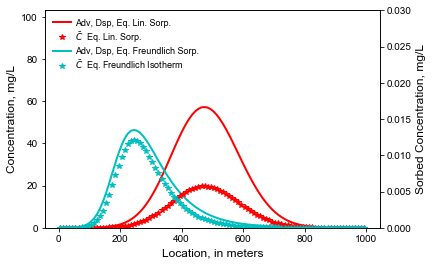

In [122]:
ucn  = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))
ucns = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001s')))

totim = ucn.get_times()

rslt_rctf = []
rslt_rctfs = []

for tm in totim:
    rsltTS = ucn.get_data(totim = tm)
    rsltTSs = ucns.get_data(totim = tm)
    rslt_rctf.append(rsltTS)
    rslt_rctfs.append(rsltTSs)

rslt_rctf = np.array(rslt_rctf)
rslt_rctfs = np.array(rslt_rctfs)


## Set up figure
try:
    plt.close('all')
except:
    pass

set_plot_params()

fig = plt.figure(figsize=(6, 4), facecolor='w')
ax = fig.add_subplot(1, 1, 1)
ax2 = plt.twinx()

lns1 = ax.plot(X[0,:], rslt_rct1[350,0,0,:], 'r-', linewidth=2.0, label = 'Adv, Dsp, Eq. Lin. Sorp.')
pts1 = ax2.plot(X[0,:], rslt_rct1s[350,0,0,:], 'r*', linewidth=2.0, label = r'$\bar{C}$  Eq. Lin. Sorp.')
lns2 = ax.plot(X[0,:], rslt_rctf[350,0,0,:], 'c-', linewidth=2.0, label = 'Adv, Dsp, Eq. Freundlich Sorp.')
pts2 = ax2.plot(X[0,:], rslt_rctfs[350,0,0,:], 'c*', linewidth=2.0, label = r'$\bar{C}$  Eq. Freundlich Isotherm')

# add 4 items to legend
lns = lns1+pts1+lns2+pts2
labs = [l.get_label() for l in lns]

#customize plot
ax.set_xlabel('Location, in meters')
ax.set_ylabel('Concentration, mg/L')
ax2.set_ylabel('Sorbed Concentration, mg/L')
ax.set_ylim([0,103])
ax2.set_ylim([0,0.03])
ticksize = 10

#legend
leg = ax.legend(lns, labs,
                loc='upper left', labelspacing=0.25, columnspacing=1,
                handletextpad=0.5, handlelength=2.0, numpoints=1)
leg._drawFrame = False 

plt.show()


What do you notice about the new curves? 

Open up the MT3D-USGS list file and have a look at the percent discrepancy Totim = 300
In a text editor, search for: 

__TOTAL ELAPSED TIME SINCE BEGINNING OF SIMULATION =   300.0000__


Let's make the curve a little more non-linear, now what do you notice with the 
  % discrepancy

What gives?

In [ ]:
rct.sp2[0][0][0,:] = 2.25 # alpha was 1.25 previously

mt.write_input()
mt.run_model()

You should see a mass balance error > 40%
I got: 
    
__DISCREPANCY (PERCENT):   -42.4314__

What is the Freundlich Isotherm:
\begin{equation*}
\bar{C} = K_f C^\alpha
\end{equation*}

Taking the derivative w.r.t. the dissolved concentration, which tells us about the slope that relates the dissolved and sorbed phases 

\begin{equation*}
\frac{\partial \bar{C}}{\partial C} = \alpha K_f C^{\alpha - 1}
\end{equation*}

Text(0,0.5,'Sorbed Concentration, $\\bar{C}$')

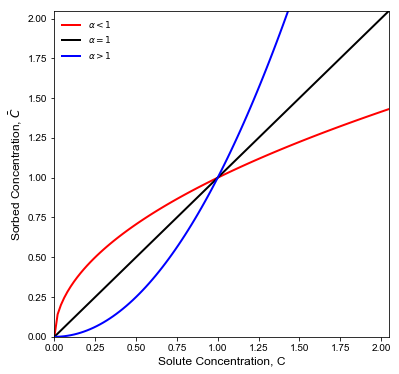

In [128]:
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


def calc_sorb_C(x, a=1, Kf=1):
    y = []
    
    for i in x:
        sorb_C = Kf*i**(a)
        y.append(sorb_C)
        
    y = np.array(y)
    return y
        
solute_C = np.arange(0.0,2.1,0.02)
sorbed_C_lt = calc_sorb_C(solute_C, a=0.5, Kf=1)
sorbed_C_eq = calc_sorb_C(solute_C, a=1, Kf=1)
sorbed_C_gt = calc_sorb_C(solute_C, a=2, Kf=1)   # try changing the 2 to a 3

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.25, hspace=0.25)

ax = fig.add_subplot(1, 1, 1)
ax.plot(solute_C, sorbed_C_lt, linewidth=2, color='red', label=r'$\alpha < 1$')
ax.plot(solute_C, sorbed_C_eq, linewidth=2, color='black', label=r'$\alpha = 1$')
ax.plot(solute_C, sorbed_C_gt, linewidth=2, color='blue', label=r'$\alpha > 1$')
ax.set_xlim([0,2.05])
ax.set_ylim([0,2.05])

leg = ax.legend(loc='upper left')
leg.draw_frame(False)
ax.set_xlabel('Solute Concentration, C')
plt.ylabel(r'Sorbed Concentration, $\bar{C}$')


So, what is the fix for the mass balance problem?  In the GCG solver package, up 'MXITER' (The maximum number of outer iterations) from 1 to 10 (or higher)

In [129]:
rct.sp2[0][0][0,:] = 1.5  # ease up on the non-linearity alpha
gcg.mxiter = 200          # give it some outer iterations to work with
gcg.isolve = 3

mt.write_input()
mt.run_model()

FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: 1D.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    100.00    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   23.97      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    1    1    6
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.8428      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    1    1    4
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   1.034      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  2:  Max. DC =  0.9095E-12  [K,I,J]    1    1    8
 Outer Iter.  4  Inner Iter.  1:  Max. DC =  0.225

 Transport Step:   57   Step Size:   1.000     Total Elapsed Time:   57.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3147E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2585E-25  [K,I,J]    1    1   74
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4208E-03  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.5722E-05  [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  4  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   58   Step Size:   1.000     Total Elapsed Time:   58.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3125E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8078E-27  [K,I,J]    1    1   78
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4151E-03  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. D

 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5031E-04  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   39   Step Size:   1.000     Total Elapsed Time:   139.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8517E-02  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5227E-04  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   40   Step Size:   1.000     Total Elapsed Time:   140.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8615E-02  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. D

 Transport Step:  137   Step Size:   1.000     Total Elapsed Time:   237.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6942E-02  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1347E-03  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  138   Step Size:   1.000     Total Elapsed Time:   238.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6895E-02  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1348E-03  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  139   Step Size:   1.0

 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  240   Step Size:   1.000     Total Elapsed Time:   340.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2735E-02  [K,I,J]    1    1    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6667E-04  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  241   Step Size:   1.000     Total Elapsed Time:   341.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2725E-02  [K,I,J]    1    1    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6568E-04  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. D

 Transport Step:  337   Step Size:   1.000     Total Elapsed Time:   437.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2466E-02  [K,I,J]    1    1    8
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2655E-04  [K,I,J]    1    1    6
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  338   Step Size:   1.000     Total Elapsed Time:   438.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2470E-02  [K,I,J]    1    1    8
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2654E-04  [K,I,J]    1    1    6
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  339   Step Size:   1.0

 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6809E-04  [K,I,J]    1    1  100
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  450   Step Size:   1.000     Total Elapsed Time:   550.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2612E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6853E-04  [K,I,J]    1    1  100
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  451   Step Size:   1.000     Total Elapsed Time:   551.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2627E-02  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

(False, [])

Now what is the new mass balance error?  [I got: DISCREPANCY (PERCENT):  -0.6998680]

### Now rerun the transport model with $\alpha$ < 1 in the Freundlich Isotherm

In [130]:
rct.sp2[0][0][0,:] = 0.5  # ease up on the non-linearity alpha

mt.write_input()
mt.run_model()


FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: 1D.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    100.00    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   23.97      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    1    1    6
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.7409E-01  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]    1    1    7
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.3234E-02  [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  2:  Max. DC =  0.7390E-12  [K,I,J]    1    1    6
 Outer Iter.  4  Inner Iter.  1:  Max. DC =  0.331

 Transport Step:   47   Step Size:   1.000     Total Elapsed Time:   47.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2835      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]    1    1   25
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1801E-02  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.1092E-04  [K,I,J]    1    1   24
 Outer Iter.  3  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  4  Inner Iter.  1:  Max. DC =  0.2170E-05  [K,I,J]    1    1   24
 Outer Iter.  4  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  5  Inner Iter.  1:  Max. DC =  0.4353E-06  [K,I,J]    1    1   24
 Transport Step:   48   Step Size:   1.000     Total Elapsed Time:   48.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2834      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Transport Step:   13   Step Size:   1.000     Total Elapsed Time:   113.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2273E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2130E-03  [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  2:  Max. DC =  0.1010E-27  [K,I,J]    1    1   49
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.6906E-05  [K,I,J]    1    1   46
 Outer Iter.  3  Inner Iter.  2:  Max. DC =  0.3469E-17  [K,I,J]    1    1   48
 Outer Iter.  4  Inner Iter.  1:  Max. DC =  0.1446E-05  [K,I,J]    1    1   46
 Outer Iter.  4  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  5  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   14   Step Size:   1.000     Total Elapsed Time:   114.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2035E-01  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  5  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   89   Step Size:   1.000     Total Elapsed Time:   189.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1792E-02  [K,I,J]    1    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1110E-15  [K,I,J]    1    1   71
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3716E-04  [K,I,J]    1    1   69
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.4622E-05  [K,I,J]    1    1   69
 Outer Iter.  3  Inner Iter.  2:  Max. DC =  0.4441E-15  [K,I,J]    1    1   71
 Outer Iter.  4  Inner Iter.  1:  Max. DC =  0.9764E-06  [K,I,J]    1    1   70
 Transport Step:   90   Step Size:   1.000     Total Elapsed Time:   190.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1782E-02  [K,I,J]    1    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]    1    1   70
 Outer Iter.  2  Inner Iter.  1:  Max. D

 Transport Step:  164   Step Size:   1.000     Total Elapsed Time:   264.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1461E-02  [K,I,J]    1    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3573E-04  [K,I,J]    1    1   91
 Outer Iter.  2  Inner Iter.  2:  Max. DC =  0.3388E-20  [K,I,J]    1    1   94
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.5292E-05  [K,I,J]    1    1   92
 Outer Iter.  3  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  4  Inner Iter.  1:  Max. DC =  0.1583E-05  [K,I,J]    1    1   92
 Outer Iter.  4  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  5  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  165   Step Size:   1.000     Total Elapsed Time:   265.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1542E-02  [K,I,J]    1    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9750E-01  [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5351E-03  [K,I,J]    1    1  100
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.3427E-05  [K,I,J]    1    1  100
 Outer Iter.  3  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  4  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  241   Step Size:   1.000     Total Elapsed Time:   341.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1014      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5499E-03  [K,I,J]    1    1  100
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. D

 Outer Iter.  4  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  335   Step Size:   1.000     Total Elapsed Time:   435.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2240      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1269E-02  [K,I,J]    1    1  100
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.6497E-05  [K,I,J]    1    1  100
 Outer Iter.  3  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  4  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  336   Step Size:   1.000     Total Elapsed Time:   436.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2241      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. D

 Transport Step:  423   Step Size:   1.000     Total Elapsed Time:   523.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2213      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2298E-02  [K,I,J]    1    1  100
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.2223E-04  [K,I,J]    1    1  100
 Outer Iter.  3  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  4  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  424   Step Size:   1.000     Total Elapsed Time:   524.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2212      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2315E-02  [K,I,J]    1    1  100
 Outer Iter.  2  Inner Iter.  2:  Max. D

 Outer Iter.  4  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  490   Step Size:   1.000     Total Elapsed Time:   590.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2084      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3467E-02  [K,I,J]    1    1  100
 Outer Iter.  2  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.5358E-04  [K,I,J]    1    1  100
 Outer Iter.  3  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  4  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  491   Step Size:   1.000     Total Elapsed Time:   591.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2081      [K,I,J]    1    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. D

(False, [])

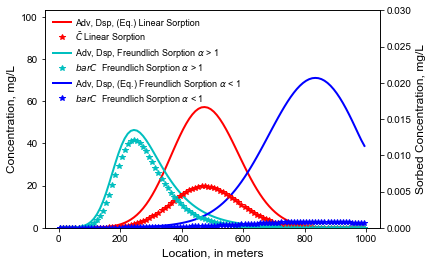

In [143]:
ucn  = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))
ucns = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001s')))

totim = ucn.get_times()

rslt_rcta = []
rslt_rctas = []

for tm in totim:
    rsltTS = ucn.get_data(totim = tm)
    rsltTSs = ucns.get_data(totim = tm)
    rslt_rcta.append(rsltTS)
    rslt_rctas.append(rsltTSs)

rslt_rcta = np.array(rslt_rcta)
rslt_rctas = np.array(rslt_rctas)

rslt_rcta.shape
rslt_rctas.shape

## Set up figure
try:
    plt.close('all')
except:
    pass

set_plot_params()

fig = plt.figure(figsize=(6, 4), facecolor='w')
ax = fig.add_subplot(1, 1, 1)
ax2 = plt.twinx()

lns1 = ax.plot(X[0,:], rslt_rct1[350,0,0,:], 'r-', linewidth=2.0, label = 'Adv, Dsp, (Eq.) Linear Sorption')
pts1 = ax2.plot(X[0,:], rslt_rct1s[350,0,0,:], 'r*', linewidth=2.0, label = r'$\bar{C}$ Linear Sorption')
lns2 = ax.plot(X[0,:], rslt_rctf[350,0,0,:], 'c-', linewidth=2.0, label = r'Adv, Dsp, Freundlich Sorption $\alpha$ > 1')
pts2 = ax2.plot(X[0,:], rslt_rctfs[350,0,0,:], 'c*', linewidth=2.0, label = r'$bar{C}$  Freundlich Sorption $\alpha$ > 1')
lns3 = ax.plot(X[0,:], rslt_rcta[350,0,0,:], 'b-', linewidth=2.0, label = r'Adv, Dsp, (Eq.) Freundlich Sorption $\alpha$ < 1')
pts3 = ax2.plot(X[0,:], rslt_rctas[350,0,0,:], 'b*', linewidth=2.0, label = r'$bar{C}$  Freundlich Sorption $\alpha$ < 1')

# add 4 items to legend
lns = lns1+pts1+lns2+pts2+lns3+pts3
labs = [l.get_label() for l in lns]

#customize plot
ax.set_xlabel('Location, in meters')
ax.set_ylabel('Concentration, mg/L')
ax2.set_ylabel('Sorbed Concentration, mg/L')
ax.set_ylim([0,103])
ax2.set_ylim([0,0.03])
ticksize = 10

#legend
leg = ax.legend(lns, labs,
                loc='upper left', labelspacing=0.25, columnspacing=1,
                handletextpad=0.5, handlelength=2.0, numpoints=1)
leg._drawFrame = False 

plt.show()
